<a href="https://colab.research.google.com/github/ravindu556/cm2604-telco-churn/blob/main/telco_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling

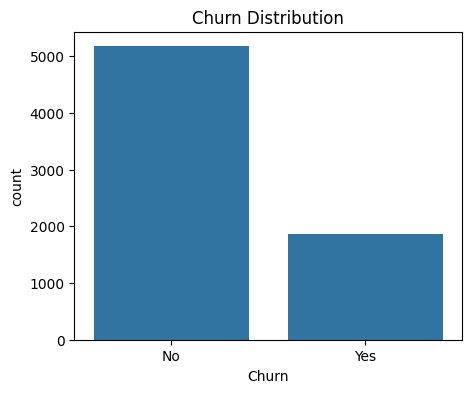

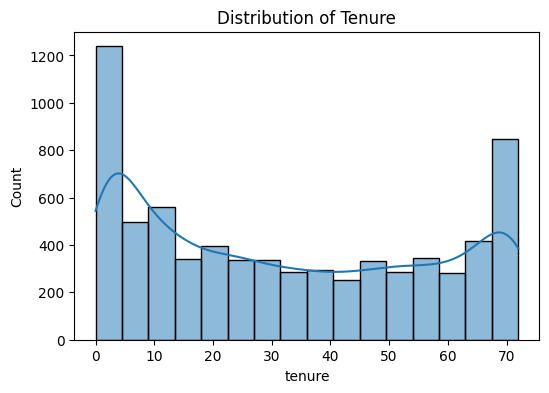

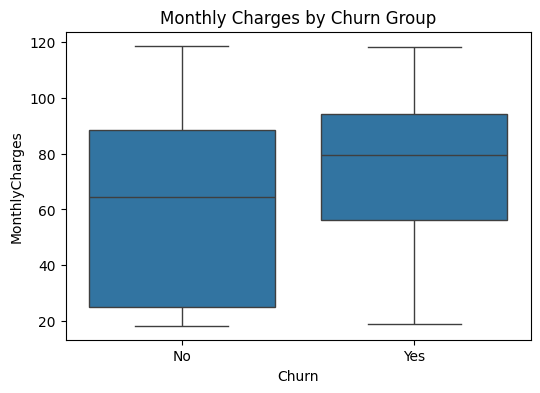

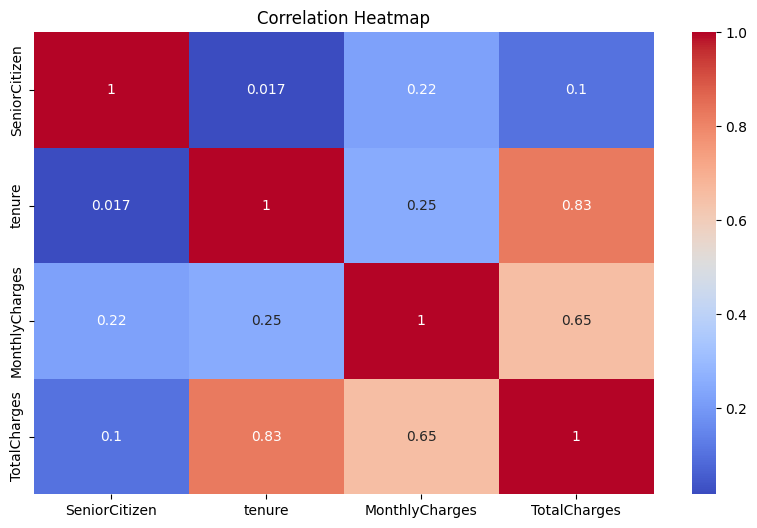

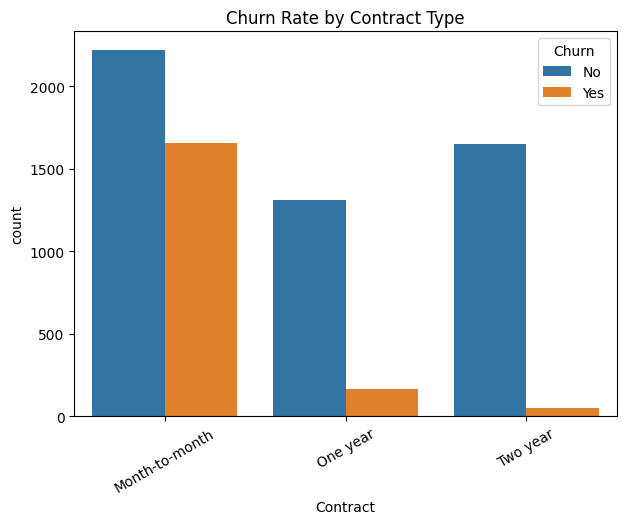

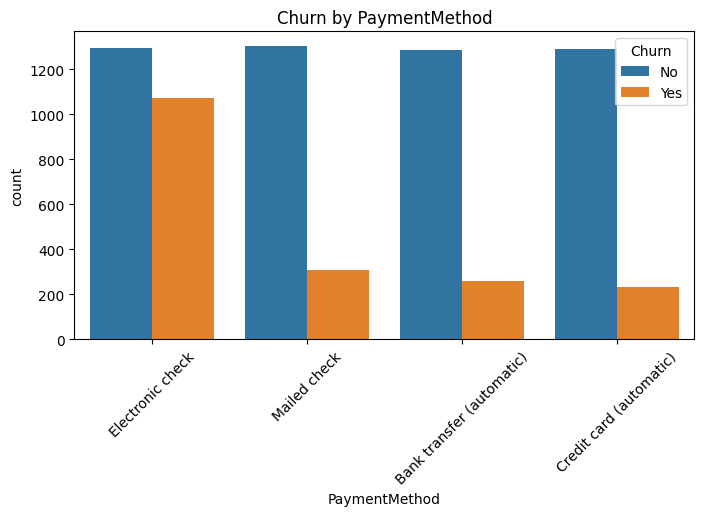

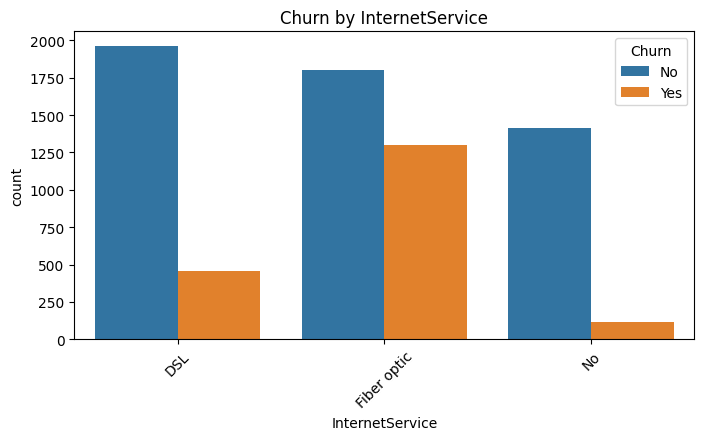

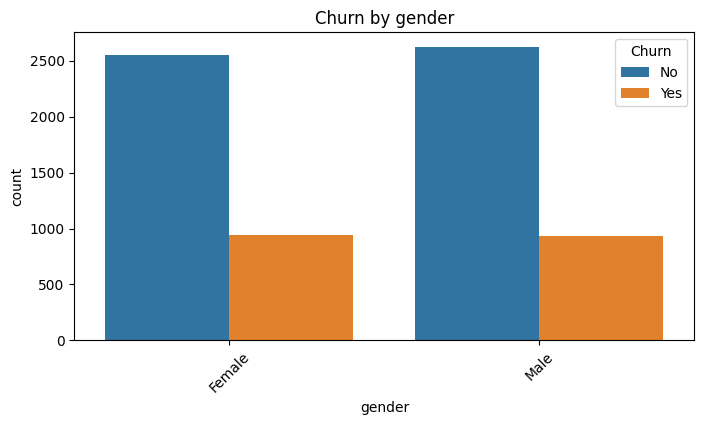

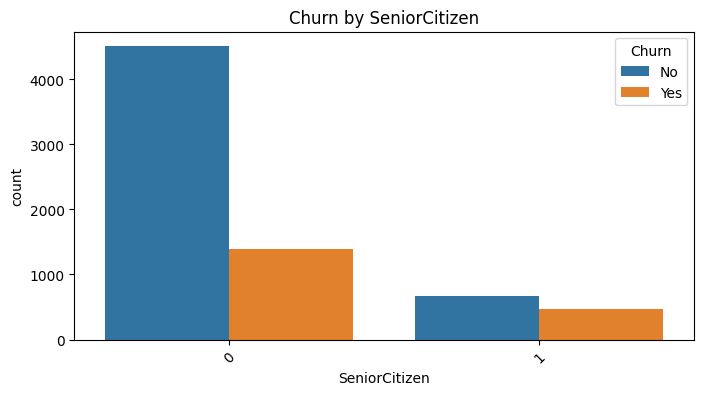

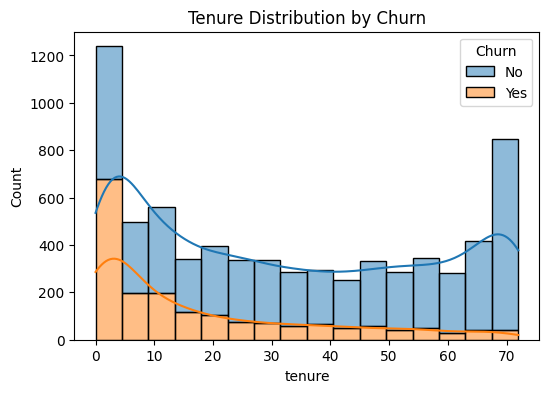

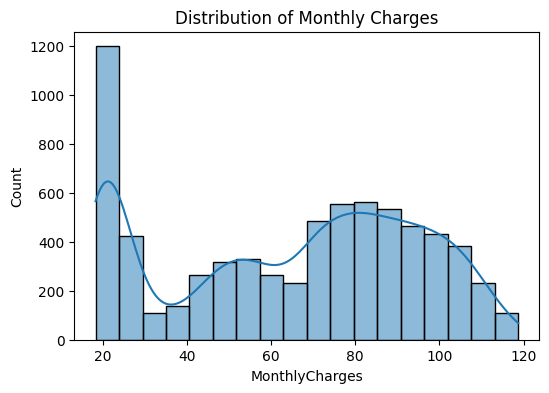

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



pd.set_option('display.max_columns', None)

# Load the Telco Customer Churn dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()


# --- Exploratory Data Analysis (EDA) ---

# Print dataset shape (rows, columns)
print("Dataset shape:", df.shape)
df.info()

# Check missing values for each column
print("Missing values per column:")
print(df.isnull().sum())

df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
print("\nMissing values after converting TotalCharges:")
print(df.isnull().sum())
#df.isnull().sum()

print("\nNumber of duplicate rows:", df.duplicated().sum())

# Summary statistics for numerical and categorical columns
df.describe(include="all")

# Check percentage of missing values
missing_percent = (df.isnull().sum() / len(df)) * 100
print("Missing values percentage:\n", missing_percent)

#  Check target variable percentages(class imbalance check)
print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)


# --- VISUALIZATIONS ---

plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df['tenure'], kde=True)
plt.title("Distribution of Tenure")
plt.show()


plt.figure(figsize=(6,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges by Churn Group")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.drop('customerID', axis=1).corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn Rate by Contract Type")
plt.xticks(rotation=30)
plt.show()


#  Churn distribution across important categorical features
categorical_cols = ['PaymentMethod', 'InternetService', 'gender', 'SeniorCitizen']
for col in categorical_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Churn by {col}')
    plt.xticks(rotation=45)
    plt.show()

#  Tenure distribution split by churn (who leaves earlier?)
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='tenure', hue='Churn', kde=True, multiple='stack')
plt.title("Tenure Distribution by Churn")
plt.show()

#  Monthly charges distribution
plt.figure(figsize=(6,4))
sns.histplot(df['MonthlyCharges'], kde=True)
plt.title("Distribution of Monthly Charges")
plt.show()





Number of duplicate rows before: 0
Number of duplicate rows after: 0


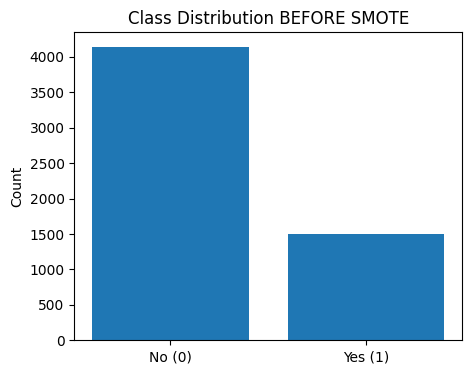


🔵 Class Distribution BEFORE SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64

Percentage:
Churn
0    73.46
1    26.54
Name: count, dtype: float64


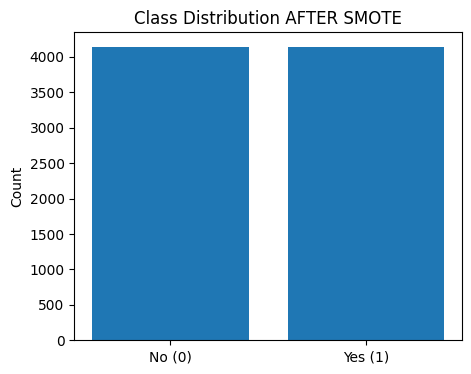


🟢 Class Distribution AFTER SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64

Percentage:
Churn
0    50.0
1    50.0
Name: count, dtype: float64
Scaling complete!


In [2]:



#  Handle the missing TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


# Check number of duplicate rows
print("Number of duplicate rows before:", df.duplicated().sum())
df.drop_duplicates(inplace=True)
print("Number of duplicate rows after:", df.duplicated().sum())


# Convert target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID
df = df.drop('customerID', axis=1)

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)

# Split data
X = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#  before BALANCING BAR CHART
plt.figure(figsize=(5,4))
plt.bar(['No (0)', 'Yes (1)'], y_train.value_counts().sort_index())
plt.title("Class Distribution BEFORE SMOTE")
plt.ylabel("Count")
plt.show()

print("\n🔵 Class Distribution BEFORE SMOTE:")
print(y_train.value_counts())
print("\nPercentage:")
print(round((y_train.value_counts() / len(y_train)) * 100, 2))


#  APPLY SMOTE
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)


#  AFTER BALANCING BAR CHART
plt.figure(figsize=(5,4))
plt.bar(['No (0)', 'Yes (1)'], y_train_bal.value_counts().sort_index())
plt.title("Class Distribution AFTER SMOTE")
plt.ylabel("Count")
plt.show()

print("\n🟢 Class Distribution AFTER SMOTE:")
print(y_train_bal.value_counts())
print("\nPercentage:")
print(round((y_train_bal.value_counts() / len(y_train_bal)) * 100, 2))

# STANDARD SCALING
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test = scaler.transform(X_test)

print("Scaling complete!")



===== Baseline Decision Tree Evaluation =====
Accuracy : 0.7132718239886444
Precision: 0.4647887323943662
Recall   : 0.5294117647058824
F1 Score : 0.495

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1035
           1       0.46      0.53      0.49       374

    accuracy                           0.71      1409
   macro avg       0.64      0.65      0.65      1409
weighted avg       0.73      0.71      0.72      1409



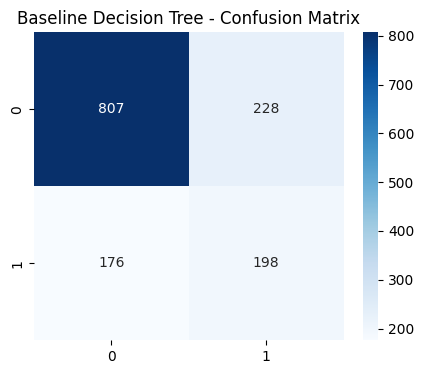

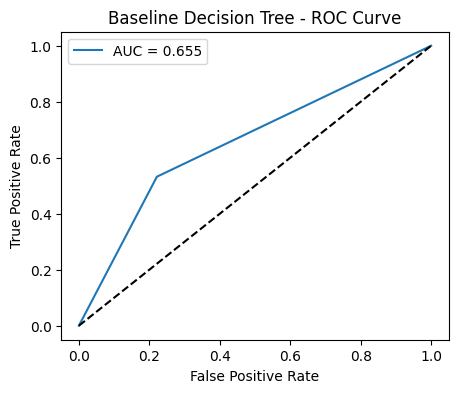

Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 4}

===== Decision Tree Evaluation =====
Accuracy : 0.7402413058907026
Precision: 0.5076923076923077
Recall   : 0.7058823529411765
F1 Score : 0.5906040268456376

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1035
           1       0.51      0.71      0.59       374

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409



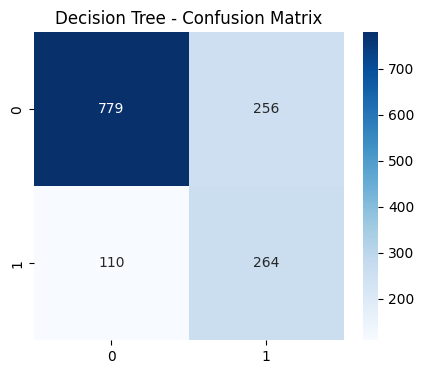

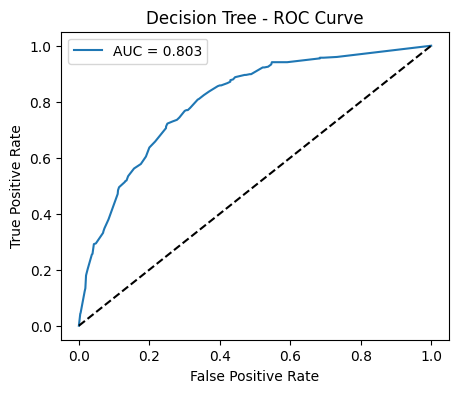

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/80
52/52 - 2s - 35ms/step - accuracy: 0.7188 - loss: 0.5448 - val_accuracy: 0.7470 - val_loss: 0.5850
Epoch 2/80
52/52 - 0s - 5ms/step - accuracy: 0.7795 - loss: 0.4700 - val_accuracy: 0.8563 - val_loss: 0.3874
Epoch 3/80
52/52 - 0s - 5ms/step - accuracy: 0.7907 - loss: 0.4489 - val_accuracy: 0.8321 - val_loss: 0.3888
Epoch 4/80
52/52 - 0s - 6ms/step - accuracy: 0.7952 - loss: 0.4420 - val_accuracy: 0.8762 - val_loss: 0.3292
Epoch 5/80
52/52 - 0s - 6ms/step - accuracy: 0.8007 - loss: 0.4298 - val_accuracy: 0.8514 - val_loss: 0.3615
Epoch 6/80
52/52 - 0s - 5ms/step - accuracy: 0.8025 - loss: 0.4291 - val_accuracy: 0.8822 - val_loss: 0.3063
Epoch 7/80
52/52 - 0s - 6ms/step - accuracy: 0.8023 - loss: 0.4207 - val_accuracy: 0.8726 - val_loss: 0.3073
Epoch 8/80
52/52 - 0s - 5ms/step - accuracy: 0.8055 - loss: 0.4129 - val_accuracy: 0.8853 - val_loss: 0.2864
Epoch 9/80
52/52 - 0s - 5ms/step - accuracy: 0.8099 - loss: 0.4138 - val_accuracy: 0.8859 - val_loss: 0.2805
Epoch 10/80
52/52 

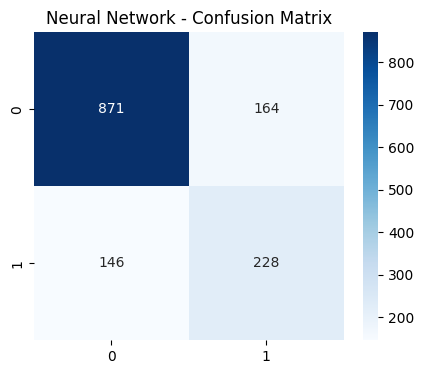

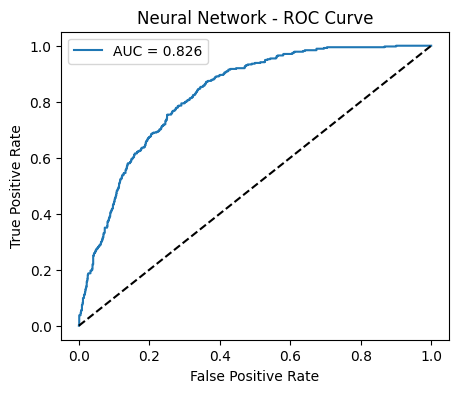

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training NN: Neurons=64, Epochs=40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Training NN: Neurons=64, Epochs=60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training NN: Neurons=128, Epochs=40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Training NN: Neurons=128, Epochs=60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

===== NN Tuning Results =====
   neurons  epochs  accuracy
0       64      40  0.778566
1       64      60  0.776437
2      128      40  0.777857
3      128      60  0.779276

Best NN Parameters: neurons     128.000000
epochs       60.000000
accuracy      0.779276
Name: 3, dtype: float64
Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7067 - loss: 0.5580 - val_accuracy: 0.7959 - val_loss: 0.4670
Epoch 2/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7820 - loss: 0.4542 - val_accuracy: 0.8569 - val_loss: 0.3751
Epoch 3/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7982 - loss: 0.4348 - val_accuracy: 0.8647 - val_loss: 0.3374
Epoch 4/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7993 - loss: 0.4237 - val_accuracy: 0.8708 - val_loss: 0.3152
Epoch 5/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8020 - loss: 0.4261 - val_accuracy: 0.8744 - val_loss: 0.3193
Epoch 6/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8045 - loss: 0.4181 - val_accuracy: 0.8847 - val_loss: 0.2873
Epoch 7/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8008 - loss: 0.4253 - val_accuracy: 0.9004 - val_loss: 0.2528
Epoch 8/60
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8134 - loss: 0.4018 - val_accuracy: 0.8635 - val_loss: 0.2999
Ep

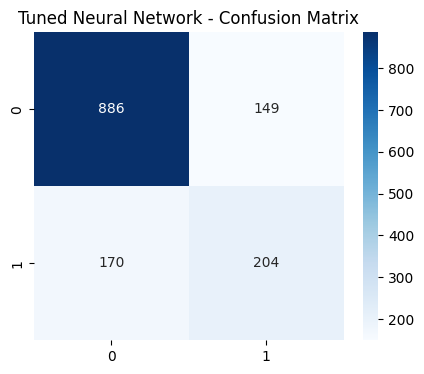

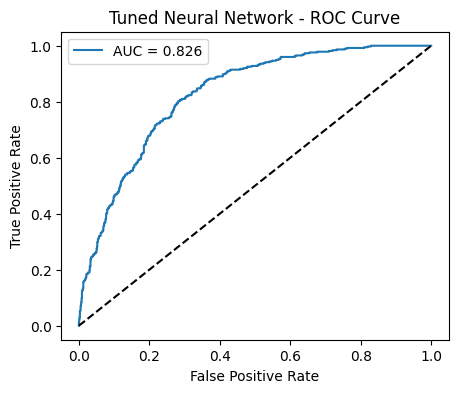


===== FINAL MODEL COMPARISON =====


,Accuracy,Precision,Recall,F1 Score
Baseline DT,0.713272,0.464789,0.529412,0.495000
Tuned DT,0.740241,0.507692,0.705882,0.590604
Baseline NN,0.779986,0.581633,0.609626,0.595300
Tuned NN,0.773598,0.577904,0.545455,0.561210


In [3]:
def evaluate_model(model_name, y_true, y_pred, y_probs=None):
    print(f"\n===== {model_name} Evaluation =====")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(model_name + " - Confusion Matrix")
    plt.show()

    # ROC Curve
    if y_probs is not None:
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc = roc_auc_score(y_true, y_probs)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
        plt.plot([0,1],[0,1],"k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(model_name + " - ROC Curve")
        plt.legend()
        plt.show()

# ===========================
# DECISION TREE CLASSIFIER
# ===========================

# ============================================
# 1️⃣ BASELINE DECISION TREE
# ============================================
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train_bal, y_train_bal)

y_pred_dt_baseline = dt_baseline.predict(X_test)
y_prob_dt_baseline = dt_baseline.predict_proba(X_test)[:,1]

evaluate_model("Baseline Decision Tree", y_test, y_pred_dt_baseline, y_prob_dt_baseline)

param_grid = {
    "max_depth": [4, 6, 8, None],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

dt = DecisionTreeClassifier(random_state=42)

grid = GridSearchCV(dt, param_grid, cv=3, scoring="f1", n_jobs=-1)
grid.fit(X_train_bal, y_train_bal)

print("Best Decision Tree Parameters:", grid.best_params_)

best_dt = grid.best_estimator_

# Predictions
y_pred_dt = best_dt.predict(X_test)
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

evaluate_model("Decision Tree", y_test, y_pred_dt, y_prob_dt)

# Save model
joblib.dump(best_dt, "DecisionTree_Model.joblib")


# ===========================
# NEURAL NETWORK CLASSIFIER
# ===========================

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_bal.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model.fit(
    X_train_bal, y_train_bal,
    validation_split=0.2,
    epochs=80,
    batch_size=128,
    callbacks=[es],
    verbose=2
)

# Predictions
y_prob_nn = model.predict(X_test).ravel()
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

evaluate_model("Neural Network", y_test, y_pred_nn, y_prob_nn)

# Save model
model.save("NeuralNetwork_Model.h5")

# ============================================
# 4️⃣ TUNED NEURAL NETWORK (MANUAL GRID SEARCH)
# ============================================

def build_model(neurons, dropout=0.3):
    model = Sequential([
        Dense(neurons, activation='relu', input_shape=(X_train_bal.shape[1],)),
        Dropout(dropout),
        Dense(neurons//2, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


neuron_options = [64, 128]
epoch_options = [40, 60]

results = []

for n in neuron_options:
    for e in epoch_options:
        print(f"\nTraining NN: Neurons={n}, Epochs={e}")

        temp_model = build_model(n)

        temp_model.fit(
            X_train_bal, y_train_bal,
            epochs=e,
            batch_size=128,
            validation_split=0.2,
            verbose=0
        )

        y_prob = temp_model.predict(X_test).ravel()
        y_pred = (y_prob >= 0.5).astype(int)

        acc = accuracy_score(y_test, y_pred)

        results.append({"neurons": n, "epochs": e, "accuracy": acc})


results_df = pd.DataFrame(results)
print("\n===== NN Tuning Results =====")
print(results_df)

best_params = results_df.sort_values(by="accuracy", ascending=False).iloc[0]
print("\nBest NN Parameters:", best_params)


# Train final tuned NN
best_nn = build_model(int(best_params["neurons"]))

best_nn.fit(
    X_train_bal, y_train_bal,
    epochs=int(best_params["epochs"]),
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

y_prob_best = best_nn.predict(X_test).ravel()
y_pred_best = (y_prob_best >= 0.5).astype(int)

evaluate_model("Tuned Neural Network", y_test, y_pred_best, y_prob_best)



# ============================================
# 5️⃣ FINAL COMPARISON TABLE
# ============================================

def get_scores(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

comparison_df = pd.DataFrame({
    "Baseline DT": get_scores(y_test, y_pred_dt_baseline),
    "Tuned DT": get_scores(y_test, y_pred_dt),
    "Baseline NN": get_scores(y_test, y_pred_nn),
    "Tuned NN": get_scores(y_test, y_pred_best),
}).T

print("\n===== FINAL MODEL COMPARISON =====")
comparison_df
